# **Soccer Ball Tracking**

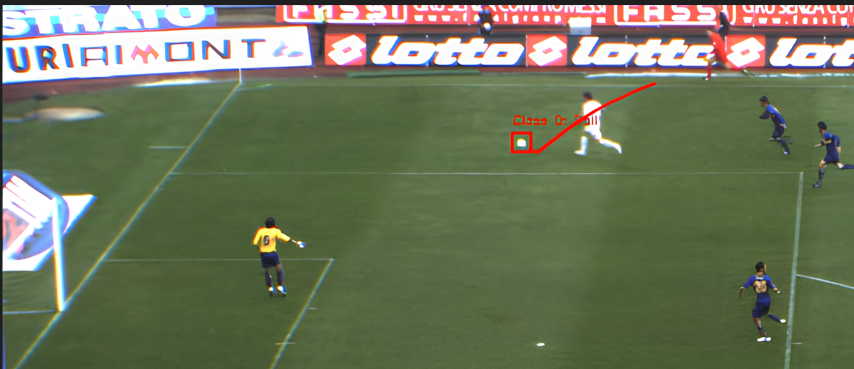

## Obiettivo

Il seguente notebook ha lo scopo di identificare la posizione ed effettuare il tracciamento di un pallone da calcio in un video, a tal fine si dovrà:
- costruire un modello di object detection/tracking e rilevare la posizione della palla frame per frame;
- Produrre un video con la traccia della posizione della palla.

### Scelta del modello

Il modello selezionato è **YOLOv11 medium**, i motivi dietro alla scelta sono molteplici:
- Alta Precisione: Ottimizzato per un bilanciamento ideale tra velocità e accuratezza nei task di rilevamento.
- Dimensione Intermedia: Modello "medium" che bilancia capacità computazionali e performance, rendendolo adatto a dispositivi con risorse hardware limitate.
- Scalabilità: Adattabile a varie risoluzioni di input per applicazioni che richiedono maggiore dettaglio o efficienza.
- Robustezza: Ottime performance su dataset complessi e in condizioni ambientali variabili.

---

## Filtraggio delle annotazioni

Prima di cominciare, è stato effettuato un processo di filtraggio delle annotazioni, eliminando quelle che presentano valori di attributo **"outside"=1** e/o **"used_in_game"=0**, questo è necessario al fine di considerare "validi" solo i palloni effettivamente presenti nel rettangolo di gioco. 

In [ ]:
import xml.etree.ElementTree as ET

def filter_xml(input_file, output_file):

    tree = ET.parse(input_file)
    root = tree.getroot()

    for track in root.findall('track'):
        count=0

        for points in track.findall('points'):

            outside = points.get('outside') == "1"
            used_in_game = False
            for attribute in points.findall('attribute'):
                if attribute.get('name') == 'used_in_game' and attribute.text == "0":
                    used_in_game = True

            if outside or used_in_game:
                count +=1
                track.remove(points)

    tree.write(output_file, encoding='utf-8', xml_declaration=True)
    print(f"File filtrato salvato in: {output_file}")
    print(f"eliminati:{count}")

filter_xml('/kaggle/input/test-annotations/ID-5.xml', '/kaggle/working/ID-5_filtered.xml')
filter_xml('/kaggle/input/test-annotations/ID-6.xml', '/kaggle/working/ID-6_filtered.xml')


---

## Analisi preliminare

### Dataset originale: verifica del bilanciamento delle etichette di training

Bilanciamento delle etichette:
File con etichette positive (non vuoti): 39.00%
File con etichette negative (vuoti): 61.00%
Totale file: 9596


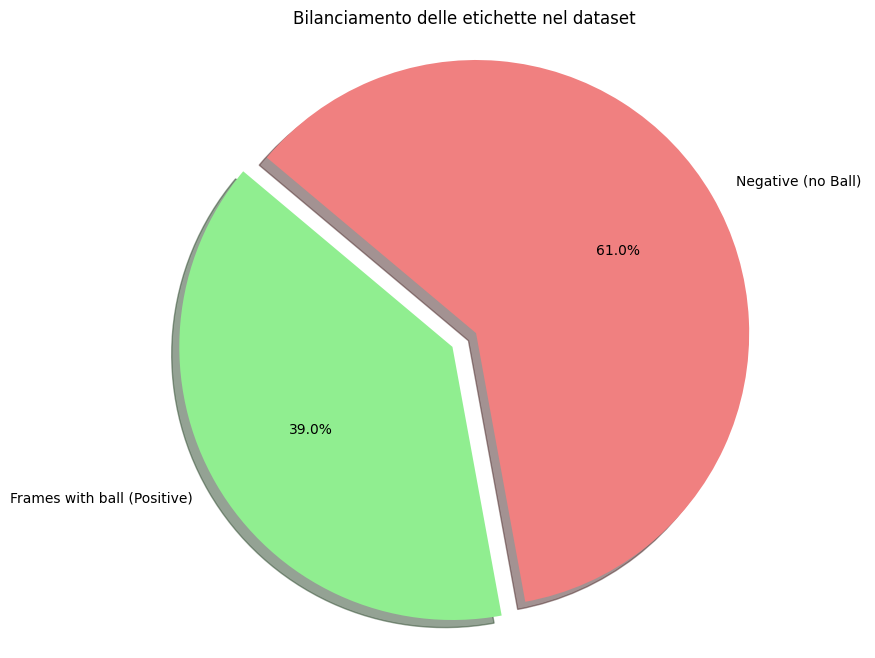

In [1]:
import os
import matplotlib.pyplot as plt

labels_path = "/kaggle/input/dataset-soccer/train/labels"

def calculate_label_balance_and_plot(labels_path):
    if not os.path.isdir(labels_path):
        print(f"La directory {labels_path} non esiste.")
        return

    positive_labels = 0
    negative_labels = 0

    for label_file in os.listdir(labels_path):
        if label_file.endswith(".txt"):
            label_file_path = os.path.join(labels_path, label_file)

            if os.path.getsize(label_file_path) > 0:
                positive_labels += 1
            else:
                negative_labels += 1

    total_files = positive_labels + negative_labels

    print("Bilanciamento delle etichette:")
    print(f"File con etichette positive (non vuoti): {(positive_labels / total_files) * 100:.2f}%")
    print(f"File con etichette negative (vuoti): {(negative_labels / total_files) * 100:.2f}%")
    print(f"Totale file: {total_files}")

    labels = ['Frames with ball (Positive)', 'Negative (no Ball) ']
    sizes = [positive_labels, negative_labels]
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Bilanciamento delle etichette nel dataset')
    plt.axis('equal')
    plt.show()

calculate_label_balance_and_plot(labels_path)


Il dataset originale presenta uno sbilanciamento verso i negativi, per ovviare a questo, si effettua un sottocampionamento di questi ultimi e un sovracampionamento dei positivi, effettuando augmentation.

### Dataset augmented: verifica del bilanciamento delle etichette di training

Bilanciamento delle etichette:
File con etichette positive (non vuoti):68.55%
File con etichette negative (vuoti): 31.45%
Totale file: 16226


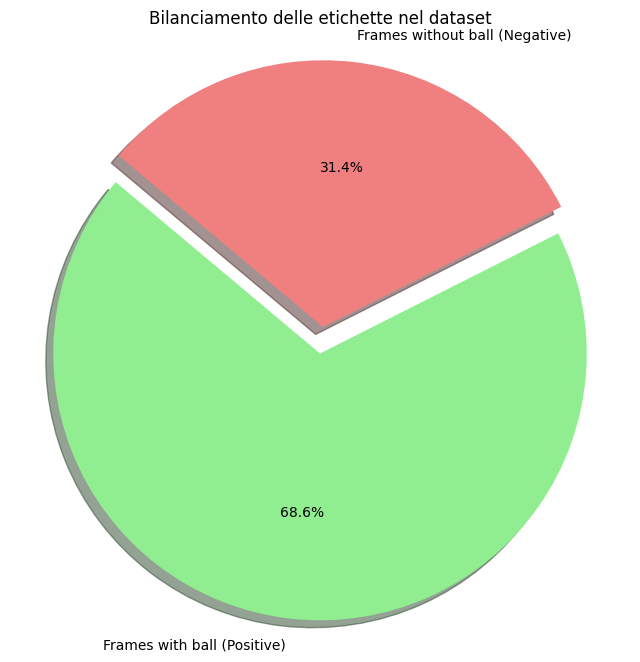

In [2]:
import os
import matplotlib.pyplot as plt

labels_path = "/kaggle/input/dataset-soccer-last/train/labels"

def calculate_label_balance_and_plot(labels_path):
    if not os.path.isdir(labels_path):
        print(f"La directory {labels_path} non esiste.")
        return

    positive_labels = 0
    negative_labels = 0

    for label_file in os.listdir(labels_path):
        if label_file.endswith(".txt"):
            label_file_path = os.path.join(labels_path, label_file)

            if os.path.getsize(label_file_path) > 0:
                positive_labels += 1
            else:
                negative_labels += 1

    total_files = positive_labels + negative_labels

    print("Bilanciamento delle etichette:")
    print(f"File con etichette positive (non vuoti):{(positive_labels / total_files) * 100:.2f}%")
    print(f"File con etichette negative (vuoti): {(negative_labels / total_files) * 100:.2f}%")
    print(f"Totale file: {total_files}")

    labels = ['Frames with ball (Positive)', 'Frames without ball (Negative) ']
    sizes = [positive_labels, negative_labels]
    colors = ['lightgreen', 'lightcoral']
    explode = (0.1, 0)

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Bilanciamento delle etichette nel dataset')
    plt.axis('equal')
    plt.show()

calculate_label_balance_and_plot(labels_path)


### Visualizzazione dei Bounding Box

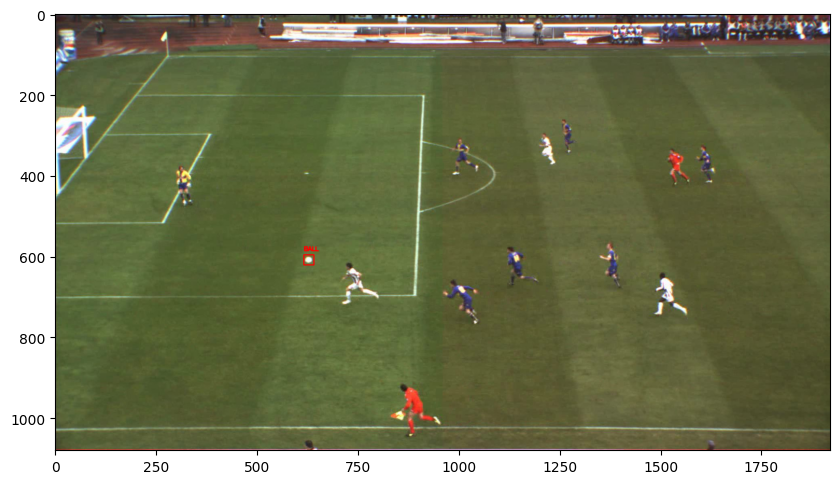

In [3]:
import cv2
import os
import matplotlib.pyplot as plt

image_path = "/kaggle/input/dataset-soccer/test/images/frame_0460_6.jpg"
label_path = "/kaggle/input/dataset-soccer/test/labels/frame_0460_6.txt"

IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1088

def draw_yolo_bboxes(image_path, label_path):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Errore: Immagine non trovata in {image_path}")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if not os.path.exists(label_path):
        print(f"Errore: File di etichetta non trovato in {label_path}")
        return

    with open(label_path, "r") as file:
        for line in file.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                print(f"Formato errato nel file di etichetta: {line}")
                continue

            class_id, x_center, y_center, box_width, box_height = map(float, parts)

            # Calcola le coordinate del bounding box
            x_center *= IMAGE_WIDTH
            y_center *= IMAGE_HEIGHT
            box_width *= IMAGE_WIDTH
            box_height *= IMAGE_HEIGHT

            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)

            image = cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, f"BALL", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.xlabel('',fontsize=12)
    plt.ylabel('',fontsize=12)
    plt.grid(False)
    plt.show()

draw_yolo_bboxes(image_path, label_path)


---

## Training

In [ ]:
import multiprocessing

if __name__ == "__main__":
    multiprocessing.set_start_method("spawn", force=True)

In [ ]:
import torch

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

In [ ]:
model = YOLO("yolo11m.pt")  # pretrained YOLO11 model

### Primo train: 5 epoche su Dataset originale

In [ ]:
yaml_path = "/kaggle/input/dataset-soccer/dataset.yaml"
if torch.cuda.is_available():
    model.train(
        data = yaml_path,
        epochs = 5,
        imgsz = 1440,
        batch = 4,
        name = "yolo11m_original",
        workers = 4,
        device = 0,
        conf = 0.2,
    )

### Secondo train: 10 epoche su dataset aumentato

In [ ]:
yaml_path = "/kaggle/input/dataset-soccer-last/dataset.yaml"
if torch.cuda.is_available():
    model.train(
        data = yaml_path,
        epochs = 5,
        imgsz = 1440,
        batch = 4,
        name = "yolo11m_augmented5",
        workers = 4,
        device = 0,
        conf = 0.2,
    )

In [ ]:
if torch.cuda.is_available():
    model.train(
        data = yaml_path,
        epochs = 5,
        imgsz = 1440,
        batch = 4,
        name = "yolo11m_augmented5+5",
        workers = 4,
        device = 0,
        conf = 0.2,
    )

## Test

In [ ]:
model = YOLO("/kaggle/input/medium_10aug/pytorch/default/1/best.pt")

### Test del modello ed estrazione delle labels con il valore di confidenza

In [ ]:
import os
from PIL import Image

test_images_path = '/kaggle/input/dataset-soccer/test/images'
output_path = '/kaggle/working/test_default_confidence'
labels_conf_path = os.path.join(output_path, 'labels_confidence')

os.makedirs(output_path, exist_ok=True)
os.makedirs(labels_conf_path, exist_ok=True)

results = model.predict(
    source=test_images_path,
    imgsz=1440,
    save=True,
    save_txt=True,
    project=output_path,
    stream=True,
)

print("Inizio test...")
for result in results:

    image_path = result.path
    image_name = os.path.basename(image_path)

    label_name = os.path.splitext(image_name)[0] + ".txt"

    label_conf_file = os.path.join(labels_conf_path, label_name)

    with Image.open(image_path) as img:
        img_width, img_height = img.size

    boxes = result.boxes

    if not boxes:
        continue  # Salta alla prossima immagine se non ci sono etichette

    with open(label_conf_file, "w") as f:
        for box in boxes:
            cls = int(box.cls.cpu().numpy())
            conf = float(box.conf.cpu().numpy())
            x_center, y_center, width, height = map(float, box.xywh.cpu().numpy()[0])

            x_center /= img_width
            y_center /= img_height
            width /= img_width
            height /= img_height

            f.write(f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f} {conf:.6f}\n")

print("Test completato.")


### Estrazione delle etichette con la confidenza massima

In [ ]:
import os

input_folder = '/kaggle/input/test-various/new_test_default_confidence/labels_confidence'
output_folder = '/kaggle/working/labels_maxconf'

os.makedirs(output_folder, exist_ok=True)

def process_file(input_file, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()

    if not lines:
        return

    # Trova il bounding box con il confidenza più alto
    max_confidence = -1
    best_line = None

    for line in lines:
        parts = line.split()
        conf = float(parts[5])  # La confidenza è l'ultimo valore (index 5)
        if conf > max_confidence:
            max_confidence = conf
            best_line = parts

    # Scrivi il bounding box con il confidenza più alto nel nuovo file
    if best_line:
        with open(output_file, 'w') as f:
            f.write(f"{best_line[0]} {best_line[1]} {best_line[2]} {best_line[3]} {best_line[4]}\n")

for filename in os.listdir(input_folder):
    if filename.endswith('.txt'):
        input_file = os.path.join(input_folder, filename)
        output_file = os.path.join(output_folder, filename)
        process_file(input_file, output_file)

---

# Post processing

## Filtro cluster


**Scopo**:

Il processo filtra le predizioni YOLO identificando e mantenendo solo i cluster di predizioni consecutive all'interno di una finestra temporale, basandosi su criteri specifici:

- Dimensione minima del cluster (*cluster_size*):
    Definisce il numero minimo di frame consecutivi contenenti predizioni affinché il cluster sia considerato valido.

- Finestra temporale (*window*):
    Indica il numero massimo di frame consecutivi senza predizioni che può essere tollerato per unire cluster vicini e trattarli come un unico gruppo.

Dopo l'identificazione, i file YOLO che appartengono a cluster validi vengono copiati nella directory di output. In questo modo, le predizioni isolate o considerate rumorose vengono eliminate.

Al termine del processo, la directory di output contiene esclusivamente i file di predizioni YOLO relativi ai cluster validi.

In [ ]:
import os
import re

def filter_clusters_predictions(label_dir, output_dir, cluster_size, window):
    """
    Filtra le predizioni basate su un cluster di predizioni consecutive all'interno di una finestra temporale.

    :param label_dir: Directory contenente i file YOLO (.txt).
    :param output_dir: Directory di output per salvare i file filtrati.
    :param cluster_size: Dimensione minima del cluster di predizioni consecutive da mantenere.
    :param window: Numero massimo di frame consecutivi senza predizioni per considerare i cluster vicini.
    """
    os.makedirs(output_dir, exist_ok=True)
    files = sorted(os.listdir(label_dir))

    def extract_frame_index_and_suffix(filename):
        match = re.search(r"frame_(\d+)_(\d+)\.txt", filename)
        return (int(match.group(1)), match.group(2)) if match else (None, None)

    # Raggruppa i file per video (suffix)
    grouped_files = {}
    for file in files:
        if file.endswith(".txt"):
            frame_index, suffix = extract_frame_index_and_suffix(file)
            if frame_index is not None:
                if suffix not in grouped_files:
                    grouped_files[suffix] = []
                grouped_files[suffix].append((frame_index, file))

    for suffix, frame_files in grouped_files.items():
        # Ordina i file per indice di frame
        frame_files = sorted(frame_files, key=lambda x: x[0])
        frame_indices = [f[0] for f in frame_files]

        to_keep = set()
        cluster = []

        for i, current_frame in enumerate(frame_indices):
            # Aggiungi il frame corrente al cluster
            cluster.append(current_frame)

            # Verifica se il cluster è completo (verifica la distanza con il prossimo frame)
            if i == len(frame_indices) - 1 or frame_indices[i + 1] - current_frame > window:
                # Mantieni il cluster solo se soddisfa la dimensione minima
                if len(cluster) >= cluster_size:
                    to_keep.update(cluster)
                cluster = []  # Ripristina il cluster per il prossimo gruppo

        print(f"Frame eliminati per video {suffix}: {sorted(set(frame_indices) - to_keep)}")

        for frame_index, file in frame_files:
            if frame_index in to_keep:
                input_path = os.path.join(label_dir, file)
                output_path = os.path.join(output_dir, file)
                with open(input_path, "r") as f_in, open(output_path, "w") as f_out:
                    f_out.writelines(f_in.readlines())

    print(f"Predizioni filtrate salvate in: {output_dir}")


filter_clusters_predictions(
    label_dir="/kaggle/working/labels_maxconf",
    output_dir="/kaggle/working/labels_cluster",
    cluster_size=25,
    window=10
)

-----

## Eliminazione delle variazioni eccessive

Se tra due predizioni contigue vi è una differenza superiore a 150 pixel tra i centri dei bounding box allora viene copiata l’etichetta precedente.

In [ ]:
import os
import numpy as np
import math

def euclidean_distance(center1, center2):
    return np.linalg.norm(np.array(center1) - np.array(center2))

def is_significantly_different(center1, center2, threshold, img_width, img_height):
    normalized_threshold = threshold / max(img_width, img_height)
    return euclidean_distance(center1, center2) > normalized_threshold

def read_yolo_label(file_path):
    with open(file_path, 'r') as f:
        line = f.readline().strip()
    label = list(map(float, line.split()))
    return label

def save_yolo_label(file_path, label):
    with open(file_path, 'w') as f:
        f.write(" ".join(map(str, label)) + "\n")

def extract_frame_number(file_name):
    parts = file_name.split('_')
    frame_number = int(parts[1])
    return frame_number

# Directory delle etichette originali
input_labels_dir = "/kaggle/working/labels_cluster"
output_labels_dir = "/kaggle/working/labels_cluster_dist"
os.makedirs(output_labels_dir, exist_ok=True)

threshold = 150
img_width, img_height = 1920, 1080

label_files = sorted(os.listdir(input_labels_dir))

video_5_files = [f for f in label_files if "_5" in f]
video_6_files = [f for f in label_files if "_6" in f]

def process_video_files(video_files, input_dir, output_dir, threshold, img_width, img_height):
    prev_label = None
    prev_frame_number = None

    for file_name in video_files:
        input_file_path = os.path.join(input_dir, file_name)
        output_file_path = os.path.join(output_dir, file_name)

        current_label = read_yolo_label(input_file_path)

        current_frame_number = extract_frame_number(file_name)

        if prev_label is not None and abs(current_frame_number - prev_frame_number) <= 2:

            current_center = current_label[1:3]
            prev_center = prev_label[1:3]

            if is_significantly_different(current_center, prev_center, threshold, img_width, img_height):

                current_label = prev_label
                print(f"Corretto: {file_name}")

        save_yolo_label(output_file_path, current_label)

        prev_label = current_label
        prev_frame_number = current_frame_number

process_video_files(video_5_files, input_labels_dir, output_labels_dir, threshold, img_width, img_height)
process_video_files(video_6_files, input_labels_dir, output_labels_dir, threshold, img_width, img_height)

---

## Interpolazione Polinomiale

In [ ]:
import os
import re
import numpy as np

def interpolate_labels_yolo(label_dir, output_dir, video_suffix, buffer_size, max_gap):
    """
    Interpola le labels mancanti nei file YOLO (.txt) utilizzando un buffer dinamico e un polinomio.

    :param label_dir: Directory contenente i file YOLO (.txt).
    :param output_dir: Directory di output per salvare le labels interpolate.
    :param video_suffix: Suffix del video da processare (es. '5' o '6').
    :param buffer_size: Numero massimo di frame etichettati da mantenere nel buffer per l'interpolazione.
    :param max_gap: Massimo numero di frame consecutivi che possono essere interpolati.
    """
    os.makedirs(output_dir, exist_ok=True)
    files = sorted(os.listdir(label_dir))

    def extract_frame_index(filename):
        match = re.search(rf"frame_(\d+)_{video_suffix}\.txt", filename)
        return int(match.group(1)) if match else None

    # Identifica i frame disponibili
    frame_indices = [(extract_frame_index(file), file) for file in files if file.endswith(".txt")]
    frame_indices = sorted([(idx, name) for idx, name in frame_indices if idx is not None])

    if not frame_indices:
        print(f"Nessun frame trovato per il video {video_suffix}.")
        return

    interpolated_frames = []
    buffer = []  # Buffer per mantenere gli ultimi frame etichettati

    # Copia tutti i file originali nella directory di output
    for file in files:
        if file.endswith(".txt"):
            input_path = os.path.join(label_dir, file)
            output_path = os.path.join(output_dir, file)
            with open(input_path, "r") as f_in, open(output_path, "w") as f_out:
                f_out.writelines(f_in.readlines())

    i = 0
    while i < len(frame_indices):
        current_frame, current_file = frame_indices[i]

        # Aggiungi il frame corrente al buffer
        with open(os.path.join(label_dir, current_file), "r") as f:
            lines = f.readlines()
            if lines:
                coords = list(map(float, lines[0].strip().split()[1:]))
                buffer.append((current_frame, coords))
                if len(buffer) > buffer_size:
                    buffer.pop(0)  # Mantieni solo gli ultimi `buffer_size` frame
            else:
                i += 1
                continue

         # Trova il prossimo frame etichettato (saltando quello successivo nella sequenza)
        j = i + 1

        while j < len(frame_indices) and frame_indices[j][0] - current_frame == 1:
            j += 1


        if j < len(frame_indices):

            next_frame_labeled, next_file_labeled = frame_indices[j]

            if next_frame_labeled - current_frame > max_gap:
                print(f"Salto l'interpolazione tra {current_frame} e {next_frame_labeled} (gap troppo grande).\n")
                i += 1
                buffer.clear()
                continue

            interpolate = True
            for missing_frame in range(current_frame + 1, next_frame_labeled):

                missing_file = f"frame_{missing_frame:04d}_{video_suffix}.txt"
                path_missing_file = os.path.join(label_dir, missing_file)
                if os.path.exists(path_missing_file):
                    interpolate = False
                    #break

            if interpolate:

                # Costruisci il polinomio utilizzando il buffer e il prossimo frame
                frames = [frame for frame, _ in buffer] + [next_frame_labeled]
                coords = [coord for _, coord in buffer]
                with open(os.path.join(label_dir, next_file_labeled), "r") as f:
                    next_coords = list(map(float, f.readlines()[0].strip().split()[1:]))
                    coords.append(next_coords)

                # Calcola i polinomi per ciascuna dimensione (x, y, w, h)
                polys = []

                '''
                - d è l'indice delle 4 dimensioni.
                - np.polyfit(x, y, grado del polinomio).
                - min(len(frames)-1, 3). Nel caso generico (buffer pieno) sarà di grado 3, altrimenti minore.
                - effettua una regressione polinomiale: cerca il polinomio che approssima la relazione tra i frame in frames
                - polyfit restituisce i coefficienti del polinomio.
                - poly1d rappresenta il polinomio come una funzione
                - ogni polinomio viene aggiunto alla lista polys
                - utile per interpolare le coordinate nei frame mancanti
                '''

                for d in range(4):
                    poly = np.polyfit(frames, [coord[d] for coord in coords], min(len(frames) - 1, 3))
                    polys.append(np.poly1d(poly))

                # Interpola i frame mancanti
                for missing_frame in range(current_frame + 1, next_frame_labeled):

                    #calcola il valore interpolato applicando il polinomio calcolato precedentemente al frame.
                    interp_values = [poly(missing_frame) for poly in polys]

                    # Limita i valori tra 0 e 1 per YOLO
                    interp_values = [max(0, min(1, v)) for v in interp_values]

                    print(f"Interpolato frame {missing_frame}: {interp_values} con buffer {buffer}")

                    # Salva i valori interpolati, massimo 6 cifre dopo la , (:6f)
                    interpolated_labels = [
                        f"0 {interp_values[0]:.6f} {interp_values[1]:.6f} {interp_values[2]:.6f} {interp_values[3]:.6f}\n"
                    ]

                    interpolated_file = f"frame_{missing_frame:04d}_{video_suffix}.txt"
                    output_path = os.path.join(output_dir, interpolated_file)

                    if not os.path.exists(output_path):
                        with open(output_path, "w") as f:
                            f.writelines(interpolated_labels)
                        interpolated_frames.append(interpolated_file)

        i += 1

interpolate_labels_yolo("/kaggle/working/labels_cluster_dist",
                        "/kaggle/working/labels_final",
                        video_suffix="5",
                        buffer_size=3,
                        max_gap=10)


interpolate_labels_yolo("/kaggle/working/labels_cluster_dist",
                        "/kaggle/working/labels_final",
                        video_suffix="6",
                        buffer_size=3,
                        max_gap=10)

---
## Json conversion

In [ ]:
import json
import os
from PIL import Image

labels_path = "/kaggle/working/labels_final"

test_images_path = '/kaggle/input/dataset-soccer/test/images'

output_json_path_5 = '/kaggle/working/json_yolo/final_5.json'
output_json_path_6 = '/kaggle/working/json_yolo/final_6.json'

os.makedirs(os.path.dirname(output_json_path_5), exist_ok=True)
os.makedirs(os.path.dirname(output_json_path_6), exist_ok=True)

output_data_5 = {}
output_data_6 = {}

test_images = [f for f in os.listdir(test_images_path) if f.endswith('.jpg')]

label_files = {f.replace('.txt', '.jpg') for f in os.listdir(labels_path) if f.endswith('.txt')}

for image_name in test_images:
    if '_5' in image_name:
        target_json = output_data_5
    elif '_6' in image_name:
        target_json = output_data_6
    else:
        continue

    stripped_image_name = image_name.replace('frame_', '').replace('_5', '').replace('_6', '')

    image_path = os.path.join(test_images_path, image_name)
    with Image.open(image_path) as img:
        original_width, original_height = img.size

    label_file_name = image_name.replace('.jpg', '.txt')
    label_file_path = os.path.join(labels_path, label_file_name)

    if image_name in label_files:
        with open(label_file_path, 'r') as f:
            lines = f.readlines()

        if lines:
            cls, x, y, w, h = map(float, lines[0].strip().split())
            x_center = x * original_width
            y_center = y * original_height
            target_json[stripped_image_name] = {"x": round(x_center, 3), "y": round(y_center, 3)}
        else:
            print(f"File di etichetta vuoto: {label_file_path}")
            target_json[stripped_image_name] = {"x": -1, "y": -1}
    else:
        target_json[stripped_image_name] = {"x": -1, "y": -1}

sorted_output_data_5 = dict(sorted(output_data_5.items(), key=lambda item: item[0]))
sorted_output_data_6 = dict(sorted(output_data_6.items(), key=lambda item: item[0]))

with open(output_json_path_5, 'w') as json_file_5:
    json.dump(sorted_output_data_5, json_file_5, indent=4)

with open(output_json_path_6, 'w') as json_file_6:
    json.dump(sorted_output_data_6, json_file_6, indent=4)

print(f"Risultati per ID_5 salvati in: {output_json_path_5}")
print(f"Risultati per ID_6 salvati in: {output_json_path_6}")



----

## Calcolo MSE


In [ ]:
import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

plt.rcParams["figure.figsize"] = (10, 8)

In [ ]:
class TrackingEvaluator:
    def __init__(self, gt_ann_file, pred_file):
        self.gt_ann_file = gt_ann_file
        self.pred_file = pred_file
        self.gt_data_points = {}
        self.pred_points = {}
        self.frames_idx = None

    @staticmethod
    def extract_points_data(xml_content):
        root = ET.fromstring(xml_content)
        points_data = {}

        for track in root.findall(".//track"):
            for point in track.findall("points"):
                data = {
                    'frame': int(point.get("frame")),
                    'outside': int(point.get("outside")),
                    'occluded': int(point.get("occluded")),
                    'keyframe': int(point.get("keyframe")),
                    'points': tuple(map(float, point.get("points").split(","))),
                    'z_order': int(point.get("z_order")),
                }
                if data['frame'] in points_data:
                    print(f'Alert: multiple frame entries for ID {data["frame"]}')
                points_data[data['frame']] = data

        return points_data

    @staticmethod
    def _convert_key(k):
        return int(Path(k).stem)

    def load_data(self):
        # Load ground truth data
        gt_content = Path(self.gt_ann_file).read_text()
        self.gt_data_points = self.extract_points_data(gt_content)

        # Load prediction data
        pred_content = Path(self.pred_file).read_text().replace('-Infinity', '-1').replace('Infinity', '-1')
        raw_pred_points = json.loads(pred_content)
        self.pred_points = {
            self._convert_key(k): v for k, v in raw_pred_points.items() if v['x'] >= 0
        }

    def compute_frame_indices(self):
        ordered_list_pred_frame = sorted(self.pred_points.keys())
        ordered_list_gt_frame = sorted(self.gt_data_points.keys())

        print(f'GT   frames: {ordered_list_gt_frame[0]} - {ordered_list_gt_frame[-1]}')
        print(f'PRED frames: {ordered_list_pred_frame[0]} - {ordered_list_pred_frame[-1]}')

        self.frames_idx = (
            min(ordered_list_gt_frame[0], ordered_list_pred_frame[0]),
            max(ordered_list_gt_frame[-1], ordered_list_pred_frame[-1]),
        )
        print(f'Frame Index Range: {self.frames_idx}')

    @staticmethod
    def is_match(x1, y1, x2, y2, threshold=4):
        p1 = np.array((x1, y1))
        p2 = np.array((x2, y2))
        euclid_dist = np.sqrt(np.dot((p1 - p2).T, (p1 - p2)))
        return euclid_dist < threshold

    def evaluate_metrics(self):
        cnt_match = 0
        cnt_no_match = 0
        cnt_no_pred = 0
        cnt_no_frame = 0

        lista_nopred = []
        lista_nomatch = []

        for i in range(self.frames_idx[0], self.frames_idx[1] + 1):
            if i not in self.gt_data_points:
                cnt_no_frame += 1
                continue
            if i not in self.pred_points:
                lista_nopred.append(i)
                cnt_no_pred += 1
                continue

            p1 = self.gt_data_points[i]
            p2 = self.pred_points[i]


            if self.is_match(*p1['points'], p2['x'], p2['y']):
                cnt_match += 1
            else:
                lista_nomatch.append(i)
                cnt_no_match += 1

        total_frames = len(self.gt_data_points)
        print(f'Total frames: {total_frames}')
        print(f'Total predictions: {len(self.pred_points)}')
        print(f'Matches: {cnt_match} ({cnt_match / total_frames:.3f})')
        print(f'No matches: {cnt_no_match} ({cnt_no_match / total_frames:.3f})')
        print(f'No predictions: {cnt_no_pred} ({cnt_no_pred / total_frames:.3f})')
        print(f'No frame data: {cnt_no_frame} ({cnt_no_frame / (self.frames_idx[1] - self.frames_idx[0] + 1):.3f})')
        print("NoPRED: ", lista_nopred)
        print("NoMatch: ", lista_nomatch)

    def compute_tracking_sequence(self):
        norm_width = 1920
        norm_height = 1080

        gt_seq = []
        pred_seq = []

        for i in range(min(self.gt_data_points.keys()), max(self.gt_data_points.keys()) + 1):
            if i in self.gt_data_points:
                if i not in self.pred_points:
                    pred_seq.append((0, 0))
                else:
                    p2 = self.pred_points[i]
                    pred_seq.append((p2['x'] / norm_width, p2['y'] / norm_height))

                x, y = self.gt_data_points[i]['points']
                gt_seq.append((x / norm_width, y / norm_height))

        return gt_seq, pred_seq

    def compute_mse(self):
        gt_seq, pred_seq = self.compute_tracking_sequence()
        mse = mean_squared_error(gt_seq, pred_seq)
        print(f'Mean Squared Error: {mse}')
        return mse

In [ ]:
gt_ann_file = '/kaggle/working/ID-5_filtered.xml'
pred_file = '/kaggle/working/json_yolo/final_5.json'

evaluator = TrackingEvaluator(gt_ann_file, pred_file)
evaluator.load_data()
evaluator.compute_frame_indices()
evaluator.evaluate_metrics()
mse5 = evaluator.compute_mse();

---

In [ ]:
gt_ann_file = '/kaggle/working/ID-6_filtered.xml'
pred_file = '/kaggle/working/json_yolo/final_6.json'

evaluator = TrackingEvaluator(gt_ann_file, pred_file)
evaluator.load_data()
evaluator.compute_frame_indices()
evaluator.evaluate_metrics()
mse6 = evaluator.compute_mse();

---

In [ ]:
print(f'FINAL MSE {np.mean([mse5, mse6])}')

---

## Creazione dei video

### Estrazione e organizzazione dei frame dalla directory delle immagini di test

In [ ]:
import os
from shutil import copy2

def copy_frames_by_suffix(frame_folder, output_dir_5, output_dir_6):

    os.makedirs(output_dir_5, exist_ok=True)
    os.makedirs(output_dir_6, exist_ok=True)

    for frame_file in os.listdir(frame_folder):
        if frame_file.endswith(".jpg"):
            # Determina il suffisso del file
            parts = frame_file.split("_")
            if len(parts) >= 3:
                video_suffix = parts[2].split(".")[0]

                if video_suffix == "5":
                    dest_dir = output_dir_5
                elif video_suffix == "6":
                    dest_dir = output_dir_6
                else:
                    continue

                frame_path = os.path.join(frame_folder, frame_file)
                dest_path = os.path.join(dest_dir, frame_file)
                copy2(frame_path, dest_path)

    print("Frame copiati.")

frame_folder = "/kaggle/input/dataset-soccer/test/images"
output_dir_5 = "/kaggle/working/extracted_frames_for_video/video_5"
output_dir_6 = "/kaggle/working/extracted_frames_for_video/video_6"

copy_frames_by_suffix(frame_folder, output_dir_5, output_dir_6)


### Video

In [ ]:
import cv2
import os
import math

def draw_bounding_boxes_with_trajectory(image_path, label_path, trajectory, max_frames, max_distance=100, color=(0, 0, 255)):

    image = cv2.imread(image_path)
    if image is None:
        print(f"Immagine non trovata: {image_path}")
        return None

    height, width, _ = image.shape
    current_position = None

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x, y, w, h = map(float, line.strip().split())

                x1 = int((x - w / 2) * width)
                y1 = int((y - h / 2) * height)
                x2 = int((x + w / 2) * width)
                y2 = int((y + h / 2) * height)

                current_position = (int(x * width), int(y * height))

                cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
                cv2.putText(image, f"Class {int(cls)}: Ball", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    if trajectory and current_position:
        last_position = trajectory[-1]
        if last_position is not None:
            distance = math.sqrt((current_position[0] - last_position[0]) ** 2 +
                                 (current_position[1] - last_position[1]) ** 2)
            if distance > max_distance:
                print(f"Variazione eccessiva ignorata: {distance:.2f} pixel")
                current_position = None

    # Disegna la traiettoria
    if trajectory and len(trajectory) > 1:
        for i in range(1, len(trajectory)):
            if trajectory[i - 1] is not None and trajectory[i] is not None:
                cv2.line(image, trajectory[i - 1], trajectory[i], color, 2)


    if current_position:
        trajectory.append(current_position)
    else:
        trajectory.append(None)

    if len(trajectory) > max_frames:
        trajectory.pop(0)

    return image

def create_video_with_bboxes_and_trajectory(image_dir, label_dir, output_video_path, fps=25, max_trajectory_seconds=0.5):

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])

    if not image_files:
        print(f"Nessuna immagine trovata nella directory: {image_dir}")
        return

    first_image_path = os.path.join(image_dir, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, _ = first_image.shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    trajectory = []  # Lista per salvare la traiettoria
    max_frames = int(max_trajectory_seconds * fps)

    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        frame_number = image_file.split("_")[1]
        video_suffix = image_file.split("_")[2].split(".")[0]
        label_file = f"frame_{frame_number}_{video_suffix}.txt"
        label_path = os.path.join(label_dir, label_file)

        annotated_image = draw_bounding_boxes_with_trajectory(image_path, label_path, trajectory, max_frames)
        if annotated_image is not None:
            video_writer.write(annotated_image)

    video_writer.release()
    print(f"Video generato con successo: {output_video_path}")

def create_videos_with_trajectory(image_dirs, label_dir, output_videos, fps=25, max_trajectory_seconds=0.5):
    for image_dir, output_video in zip(image_dirs, output_videos):
        create_video_with_bboxes_and_trajectory(image_dir, label_dir, output_video, fps, max_trajectory_seconds)

print("Creando i video con traiettoria...")
image_dirs = [
    "/kaggle/working/extracted_frames_for_video/video_5",
    "/kaggle/working/extracted_frames_for_video/video_6"
]
label_dir = "/kaggle/working/labels_final"
output_videos = [
    "/kaggle/working/video_5.mp4",
    "/kaggle/working/video_6.mp4"
]

create_videos_with_trajectory(image_dirs, label_dir, output_videos, fps=25, max_trajectory_seconds=0.5)
